# Artificial Persuasive Intelligence

In [3]:
pip install chromadb

  Using cached chromadb-1.0.4-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.9 kB)
  Using cached build-1.2.2.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached chroma_hnswlib-0.7.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (252 bytes)
  Using cached fastapi-0.115.9-py3-none-any.whl.metadata (27 kB)
  Using cached posthog-3.25.0-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached onnxruntime-1.21.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (4.5 kB)
  Using cached opentelemetry_exporter_otlp_proto_grpc-1.32.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached opentelemetry_instrumentation_fastapi-0.53b1-py3-none-any.whl.metadata (2.2 kB)
  Using cached pypika-0.48.9-py2.py3-none-any.whl
  Using cached kubernetes-32.0.1-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached mmh3-5.1.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (16 kB)
  Using cac

## Libraries

In [2]:
from datasets import load_dataset, Value, Sequence, Features
import chromadb
import pandas as pd
import re
import numpy as np 
#import chuck_gpt
import concurrent
import boto3
from datetime import datetime as dt
import inspect

from importlib import reload
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, DotProduct
from scipy.stats import ecdf, norm
import random
import requests
import json
#import chuck_gpt

## Load Data from Huggingface

In [3]:
#metadata = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_All_Beauty", split="full")
department = 'Home_and_Kitchen'
metadata = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_{}".format(department), split="full")


Reusing dataset amazon_review2023 (/home/sagemaker-user/.cache/huggingface/datasets/McAuley-Lab___amazon_review2023/raw_meta_Home_and_Kitchen/0.0.0/16b76e0823d73bb8cff1e9c5e3e37dbc46ae3daee380417ae141f5e67d3ea8e8)


In [4]:
features_example = Features({'rating': Value(dtype='float'),
 'title': Value(dtype='string'),
 'text': Value(dtype='string'),
 'images': Sequence(feature=Value(dtype='string'), id=None),
 'asin':  Value(dtype='string'),
 'parent_asin':  Value(dtype='string'),
 'user_id': Value(dtype='string'),
 'timestamp': Value(dtype='int64'),
 'helpful_vote': Value(dtype='int32'),
 'verified_purchase': Value(dtype='bool')})

### Just use products with descriptions

In [5]:
department = 'Home_and_Kitchen'
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Home_and_Kitchen", features=features_example)


Using custom data configuration raw_review_Home_and_Kitchen-8e916b816ac3c3e0
Reusing dataset amazon_review2023 (/home/sagemaker-user/.cache/huggingface/datasets/McAuley-Lab___amazon_review2023/raw_review_Home_and_Kitchen-8e916b816ac3c3e0/0.0.0/16b76e0823d73bb8cff1e9c5e3e37dbc46ae3daee380417ae141f5e67d3ea8e8)


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
reviews_df = pd.DataFrame(dataset['full'][slice(0, 400000)])
reviews_df['review_length'] = [len(r) for r in reviews_df['text']]  
reviews_df = reviews_df[reviews_df['review_length'] < 4000]

matched = []
for k in range(5):
    products_df = pd.DataFrame(metadata[(k*100000):((k+1)*100000)])
    products_df = products_df[[True  if len(x) > 0 else False for x in products_df['description']]]
    matched.append(reviews_df[['rating', 'text', 'asin', 'parent_asin']].\
                   merge(products_df[['title', 'average_rating', 'rating_number', 'description', 'price', 'images', 'parent_asin']], on='parent_asin').copy())
    del products_df

In [8]:
df = pd.concat(matched, axis=0)
df.shape

(72852, 10)

In [9]:
descriptions = df[['asin', 'parent_asin', 'description', 'average_rating', 
                   'title', 'price', 'rating_number', 'images']].drop_duplicates(subset='parent_asin', inplace=False)
descriptions.shape

(25106, 8)

In [10]:
matched_reviews_df = df[['parent_asin', 'title', 'text', 'rating']]

In [11]:
matched_reviews_df.to_csv('{}_reviews.csv'.format(department), index=False)

In [18]:
pip install sentence_transformers

Note: you may need to restart the kernel to use updated packages.


In [27]:
#descriptions['title_y']
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import expon
from matplotlib import pyplot as plt

In [22]:
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
title_embeddings = [embedding_model.encode([t for t in descriptions['title']])]
descriptions['embeddings'] = [x for x in title_embeddings[0]]

In [23]:
with_price = descriptions[descriptions['price'] != 'None']

In [24]:
# convert to exponential distributuion to 'fill in' missings

E = ecdf([float(x) for x in with_price['price']])
y_norm = [x * .9999 + .00005 for x in E.cdf.evaluate([float(x) for x in with_price['price']])]

X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(with_price['embeddings'], y_norm, test_size=0.33, random_state=42)
scale = RobustScaler()
scale.fit(X_train_title.to_list())
scaled_X_train_title = scale.transform(X_train_title.to_list())
scaled_X_test_title = scale.transform(X_test_title.to_list())
regr =  SVR(C=.5, degree=3, epsilon=0.1)
regr.fit(scaled_X_train_title, y_train_title)
r2_score(y_test_title, regr.predict(scaled_X_test_title))

0.5525758177164003

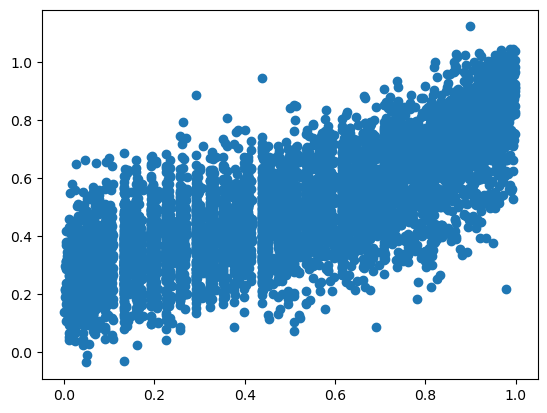

In [28]:
plt.scatter(y_test_title, regr.predict(scaled_X_test_title))

In [ ]:
scale = RobustScaler()
scale.fit([e for e in with_price['embeddings']])
production_regr =  SVR(C=.5, degree=3, epsilon=0.05)
production_regr.fit(scale.transform([e for e in with_price['embeddings']]), y_norm)


SVR(C=0.5, epsilon=0.05)

In [ ]:
mu = np.mean([float(x) for x in with_price['price']])
print(mu)
predicted_price = production_regr.predict(scale.transform([e for e in descriptions['embeddings']]))

53.2754630512515


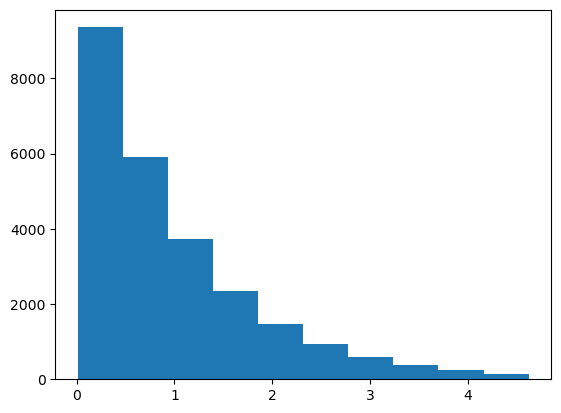

In [31]:
predicted_price_distribution = ecdf(predicted_price)
u = predicted_price_distribution.cdf.evaluate(predicted_price)
p = expon.ppf(u*.99, 1/79.2218)
h = plt.hist(p)
descriptions['predicted_price'] = [1+round(x, 2) for x in p]

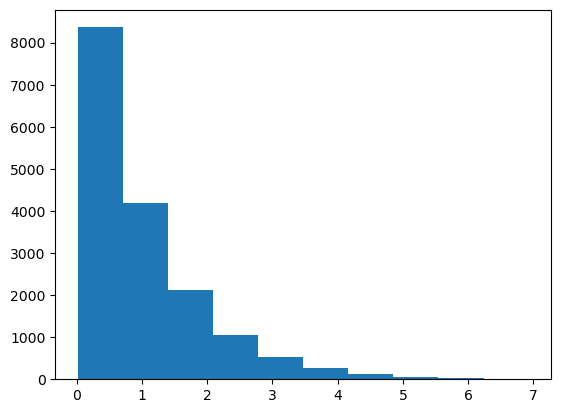

In [34]:
price_distribution = ecdf([float(x) for x in with_price['price']])
uniform = price_distribution.cdf.evaluate([float(x) for x in with_price['price']])
h = plt.hist(expon.ppf(uniform*.999, 1/mu))

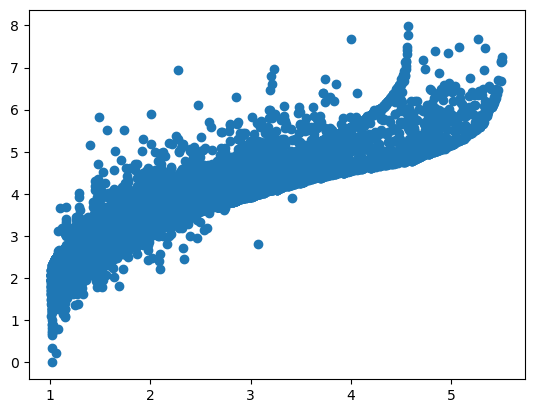

In [32]:
plt.scatter(descriptions[descriptions['price'] != 'None']['predicted_price'], 
         [np.log(float(x)) for x in descriptions[descriptions['price'] != 'None']['price']])

In [33]:
#descriptions.to_csv('beauty_descriptions_w_predicted_price.csv')
descriptions.to_csv('{}_descriptions_w_predicted_price.csv'.format(department))


In [44]:
volume = 4
client = chromadb.PersistentClient(path="/home/sagemaker-user/user-default-efs/projects/persuasio/persuasio/chroma_{}_{}".format(department, volume))
description_db = client.create_collection(name="amazon_{}_descriptions_{}".format(department, volume))


In [ ]:
start = (volume - 1) * 5000
end = volume * 5000
description_db.add(
    documents=[x[0] for x in descriptions['description'].iloc[start:end]],
    ids=[str(x) for x in descriptions['parent_asin'].iloc[start:end]], # parent_asin makes it easier for now
    metadatas=[{'average_rating': r,
                'price': p,
                'rating_number': c,
#                'hi_res': "\n".join(i['hi_res']),
                'large': "\n".join(i['large']),
                'thumb': "\n".join(i['thumb']),
                'title': t} for r, p, c, i, t in zip(descriptions['average_rating'].iloc[start:end],
                                                     descriptions['predicted_price'].iloc[start:end],
                                                     descriptions['rating_number'].iloc[start:end],
                                                     descriptions['images'].iloc[start:end],
                                                     descriptions['title'].iloc[start:end])] # could pull this later
) 

In [46]:
pwd

'/mnt/custom-file-systems/efs/fs-0efe0723c8fe23def_fsap-009815092600551f0/projects/persuasio/notebooks'

In [38]:
description_db.count()

5000